In [2]:
import pandas as pd

# Import the CSV and print out details to understand the data.
df = pd.read_csv("data/energy_usage.csv", parse_dates=["date"])
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58936 entries, 0 to 58935
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           58936 non-null  datetime64[ns]
 1   megawatthours  58936 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 921.0 KB


,date,megawatthours
0,2015-07-01 05:00:00,162827
1,2015-07-01 06:00:00,335153
2,2015-07-01 07:00:00,333837
3,2015-07-01 08:00:00,398386
4,2015-07-01 09:00:00,388954


<Axes: title={'center': 'US Hourly Electricity Demand (MWH)'}, xlabel='date', ylabel='Megawatt hours (MGH)'>

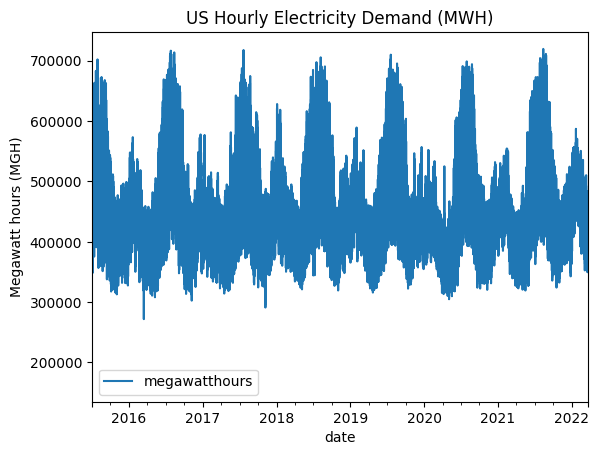

In [3]:
# Plot the raw data
df.plot(title="US Hourly Electricity Demand (MWH)", x="date", y="megawatthours", ylabel="Megawatt hours (MGH)")

In [4]:
# Hourly is too granular for this use case. Resample the data to look at monthly demand instead.
df_monthly = df.resample("1M", on="date").mean().reset_index()

df_monthly.head()

,date,megawatthours
0,2015-07-31,519010.240866
1,2015-08-31,490449.064516
2,2015-09-30,475740.758333
3,2015-10-31,410541.775538
4,2015-11-30,408467.400000


<Axes: title={'center': 'US Monthly Electricity Demand (MWH)'}, xlabel='date', ylabel='Megawatt hours (MGH)'>

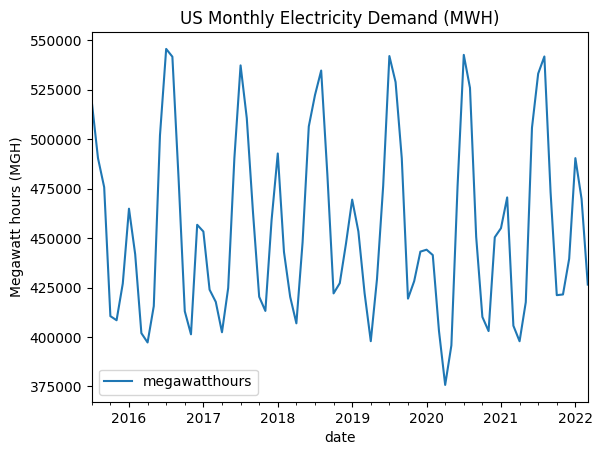

In [5]:
# Plot the new daily data.
df_monthly.plot(title="US Monthly Electricity Demand (MWH)", x="date", y="megawatthours", ylabel="Megawatt hours (MGH)")

In [6]:
msk = (df_monthly.index < len(df_monthly) - 30)
df_train = df_monthly[msk].copy()
df_test = df_monthly[~msk].copy()

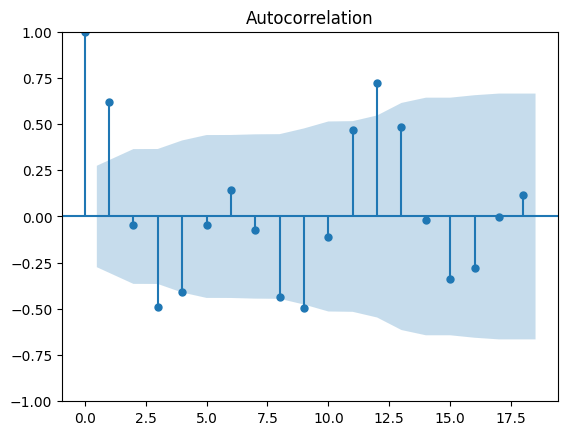

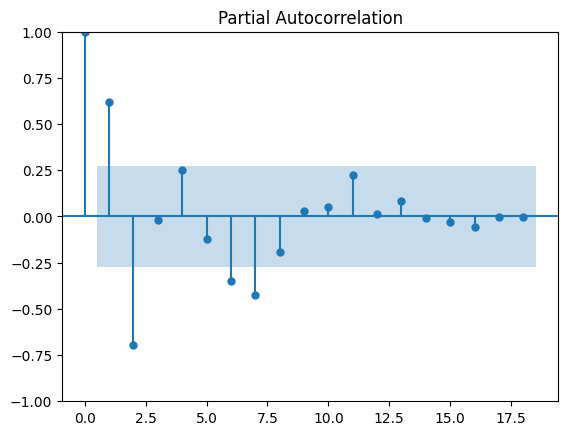

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train["megawatthours"])
pacf_original = plot_pacf(df_train["megawatthours"])

<Axes: >

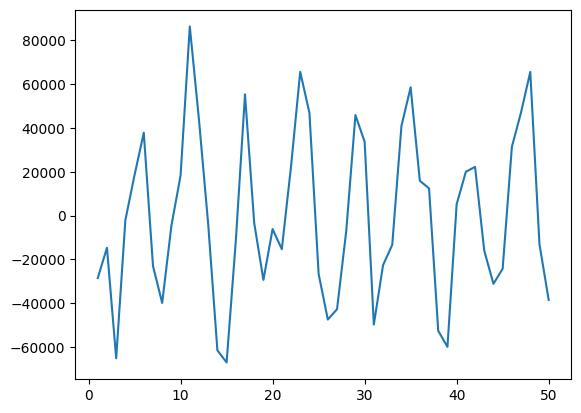

In [8]:
df_train_diff = df_train["megawatthours"].diff().dropna()
df_train_diff.plot()

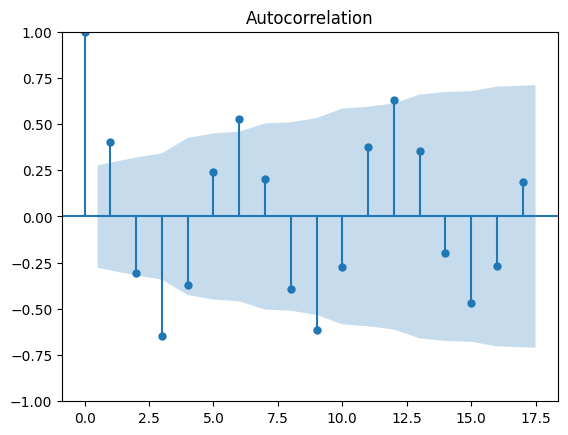

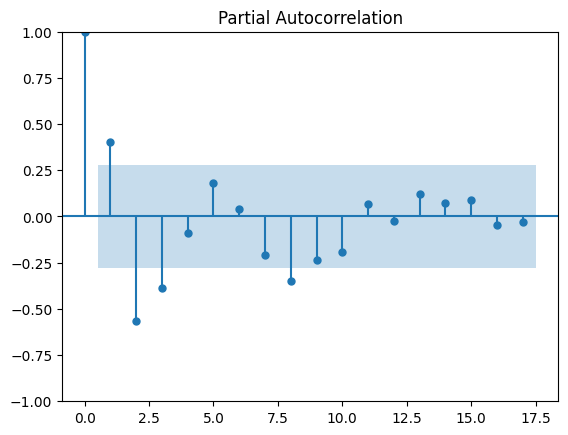

In [9]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df_monthly["megawatthours"], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
model_fit.summary()

c:\Users\tyler\development\sentiment-analysis-c964\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      megawatthours   No. Observations:                   81
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -770.244
Date:                            Sat, 27 Jan 2024   AIC                           1550.487
Time:                                    22:48:53   BIC                           1561.585
Sample:                                         0   HQIC                          1554.884
                                             - 81                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6436      0.156     -4.122      0.000      -0.950      -0.338
ma.L1          0.5446      0.177      3.077      0.002       0.198       0.892
ar.S.L12       0.6955      0.064     10.873      0.000       0.570       0.821
ma.S.L12      -1.0000      0.182     -5.508      0.000      -1.356      -0.644
sigma2      3.169e+08   5.73e-10   5.53e+17      0.000    3.17e+08    3.17e+08
===================================================================================
Ljung-Box (L1) (Q):                   7.63   Jarque-Bera (JB):                 1.38
Prob(Q):                              0.01   Prob(JB):                         0.50
Heteroskedasticity (H):               1.17   Skew:                             0.24
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.89e+33. Standard errors may be unstable.
"""

Mean Absolute Error (MAE): 15481.687736922579
Mean Absolute Percentage Error (MAPE): 0.034134541492041086
Root Mean Square Error (RMSE): 19385.529519126438


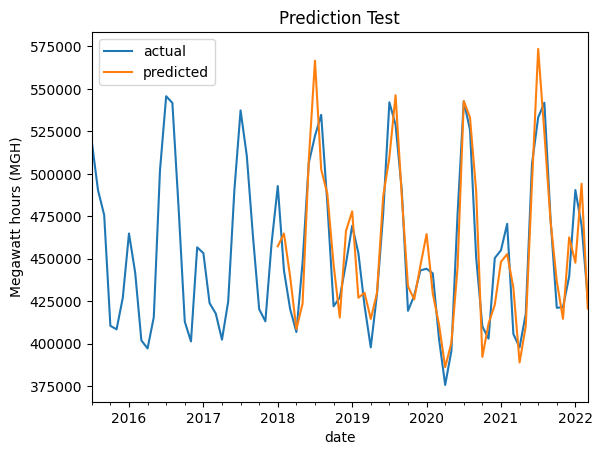

In [11]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

PREDICTION_START = len(df_test)

prediction_test = df_monthly.copy().rename(columns={"megawatthours": "actual"})

prediction_test["predicted"] = model_fit.predict(start=PREDICTION_START)
prediction_test.plot(title="Prediction Test", x="date", ylabel="Megawatt hours (MGH)")

actual = prediction_test.iloc[len(prediction_test) - PREDICTION_START:]["actual"]
predicted = prediction_test.iloc[len(prediction_test) - PREDICTION_START:]["predicted"]

mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Root Mean Square Error (RMSE): {rmse}')

TypeError: unhashable type: 'list'

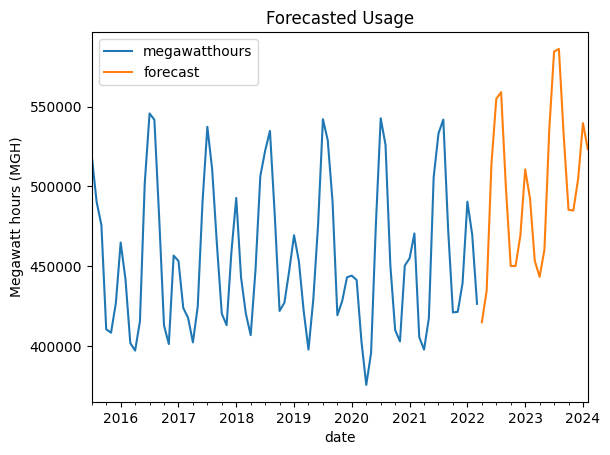

In [12]:
from pandas.tseries.offsets import DateOffset

future_dates = [df_monthly.iloc[-1]["date"] + DateOffset(months=x) for x in range(1,24)]
df_future = pd.DataFrame(columns=df_monthly.columns)
df_future["date"] = future_dates

df_future.tail()

df_prediction = pd.concat([df_monthly, df_future]).set_index("date").reset_index()
df_prediction["forecast"] = model_fit.predict(start=len(df_monthly), end=len(df_monthly) + 24)

df_prediction.plot(title="Forecasted Usage", x="date", ylabel="Megawatt hours (MGH)")

# null_mask = df_prediction.isnull().all([["forecast", "megawatthours"]])
null_rows = df_prediction.query("forecast != forecast and megawatthours != megawatthours")
# df_prediction.tail()

null_rows